In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from datetime import *
import math

In [2]:
ping_csv = pd.read_csv("../data/measure_ping.csv")
bw_csv = pd.read_csv("../data/measure_bw.csv")
weather_csv = pd.read_csv("../data/measure_weather.csv")

# Impact of weather on ping

In [3]:
weather_array = np.array(weather_csv)
weather_cond = np.unique(weather_array[:,1])
print(weather_cond)

['/staticfiles/images/picto/v2/bc/day/cloudy.png'
 '/staticfiles/images/picto/v2/bc/day/cover.png'
 '/staticfiles/images/picto/v2/bc/day/lightcloudy.png'
 '/staticfiles/images/picto/v2/bc/day/lightrain.png'
 '/staticfiles/images/picto/v2/bc/day/rain.png'
 '/staticfiles/images/picto/v2/bc/day/sun.png'
 '/staticfiles/images/picto/v2/bc/night/cloudy.png'
 '/staticfiles/images/picto/v2/bc/night/cover.png'
 '/staticfiles/images/picto/v2/bc/night/lightcloudy.png'
 '/staticfiles/images/picto/v2/bc/night/lightsun.png'
 '/staticfiles/images/picto/v2/bc/night/mostcloudy.png'
 '/staticfiles/images/picto/v2/bc/night/sun.png']


In [4]:
weather_type = []
for cond in weather_cond:
    weather_type.append(cond.split("/")[7].split(".")[0])
weather_type = np.unique(weather_type)
print(weather_type)

['cloudy' 'cover' 'lightcloudy' 'lightrain' 'lightsun' 'mostcloudy' 'rain'
 'sun']


**Fusion** of the ping measure and the weather measure in one matrix

In [5]:
"""
    Fusion csv as a np.array of measure and weather_csv : the measure of weather
"""
def fusion_with_weather(csv, weather_csv):
    fusion = []
    index2 = 0
    for i in range(len(csv)):
        if(index2 >= len(weather_csv)):
            return fusion;
        date1 = datetime.strptime(csv[i][0][0:13], "%Y-%m-%d %H")
        date2 = datetime.strptime(csv2[index2][0][0:13], "%Y-%m-%d %H") + timedelta(hours=1)
        if(date1 == date2):
            fusion.append(np.ndarray.tolist(csv[i]) + np.ndarray.tolist(weather_csv[index2][1:]))
        elif(date1 > date2):
            i -= 1
            index2 +=1
    return fusion

In [6]:
ping_array = np.array(ping_csv)
ping_weather_array = fusion_with_weather(np.array(ping_csv), np.array(weather_csv))

Create a dictionnary { 'weather condition' : '[ping measure]' }

In [7]:
"""
    Create a dictionnary with key = weather_type and value the ping measure took with this weather
"""
def create_weather_ping_dict(weather_type, ping_weather_array, server=[]):
    weather_ping_dict = {}
    for type in weather_type:
        weather_ping_dict[type] = []

    for entry in ping_weather_array:
        if(server==[]): #Take ping measure of all servers
            weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
        elif(server != []): #Take only ping of the selected server
            if(entry[1] in server):
                weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
    return weather_ping_dict

In [8]:
"""
    Compute mean pings of a string array of double, ignore NaN
"""
def mean_ping(pings):   
    array = literal_eval(pings)
    measures = np.array(array).astype(np.double)
    
    tot = 0
    non_nan = 0
    for i in range(len(measures)):
        if(not math.isnan(measures[i])):
            tot += measures[i]
            non_nan += 1
    if(non_nan == 0):
        return float('NaN')
    return tot/non_nan

In [9]:
def mean_ping_resp_weather(weather_ping_measure_dict, key):
    weather_pings = {}
    for type in key:
        weather_pings[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        non_nan = 0;
        for mes in weather_ping_measure_dict[type]:
            mean = mean_ping(mes[2])
            if(math.isnan(mean)):
                continue
            tot += mean_ping(mes[2])
            non_nan += 1;
        if(non_nan == 0):
            print("ALL measurement are NaN")
            weather_pings[type] = 'NaN'
        weather_pings[type] = tot/non_nan
    return weather_pings

In [10]:
def dictonary_to_tuple(dic):
    array_tuple = []
    for type,mean in dic.items():
        array_tuple.append((type,mean))
    return array_tuple

Servers list :

In [11]:
ping_weather_array = np.array(ping_weather_array)
servers = np.unique(ping_weather_array[:,1]).tolist()
servers.remove("iperf.par2.as49434.net") # remove iperf.par2.as49434.net because it stop working
print(servers)

['iperf.biznetnetworks.com', 'iperf.eenet.ee', 'iperf.scottlinux.com', 'speedtest.uztelecom.uz']


### Wheather measurment

In [12]:
weather_array = np.array(weather_csv)
weather_type_measurment = {}
for type in weather_type:
    weather_type_measurment[type] = 0
    
for entry in weather_array:
    weather_type_measurment[entry[1].split("/")[7].split(".")[0]] += 1;
    
array_tuple = dictonary_to_tuple(weather_type_measurment)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)    

[('mostcloudy', 1), ('rain', 1), ('lightsun', 2), ('lightrain', 4), ('cloudy', 17), ('lightcloudy', 19), ('sun', 24), ('cover', 27)]


### Ping all servers

In [13]:
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array)
weather_pings = mean_ping_resp_weather(weather_ping_measure_dict, weather_type)

In [14]:
array_tuple = dictonary_to_tuple(weather_pings)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('rain', 0.14434405683062643), ('lightrain', 0.14449552542797084), ('lightsun', 0.1447602755273067), ('sun', 0.14622336385252435), ('cover', 0.1463721185033537), ('lightcloudy', 0.14720876095590732), ('mostcloudy', 0.1473016696252833), ('cloudy', 0.1483807408548644)]


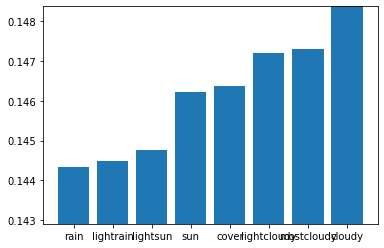

In [15]:
plt.bar(*zip(*array_tuple))
plt.ylim(array_tuple[0][1]*0.99, array_tuple[len(array_tuple)-1][1])
plt.show()

### Ping each servers

Compute mean ping depending of the weather for all **independent SERVER**

In [16]:
for SERVER in servers:
    weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, [SERVER])
    weather_pings = mean_ping_resp_weather(weather_ping_measure_dict, weather_type)
    array_tuple = dictonary_to_tuple(weather_pings)
    array_tuple.sort(key=lambda tup: tup[1])
    print(SERVER)
    print(array_tuple)
    print()

iperf.biznetnetworks.com
[('lightsun', 0.2719573360681534), ('cover', 0.27594645735787343), ('cloudy', 0.27771484117139217), ('rain', 0.27778483271598814), ('lightrain', 0.27802987456321715), ('sun', 0.279971942379054), ('mostcloudy', 0.2809595537185669), ('lightcloudy', 0.2836514140661403)]

iperf.eenet.ee
[('lightrain', 0.06659990247927214), ('rain', 0.06690799625296341), ('cover', 0.06810699030437431), ('lightcloudy', 0.06845395388695673), ('cloudy', 0.0689934900513402), ('sun', 0.06919595773340897), ('lightsun', 0.06990960259186596), ('mostcloudy', 0.07024613305142051)]

iperf.scottlinux.com
[('rain', 0.18626684257858675), ('cover', 0.1877378650834097), ('sun', 0.18817749524064228), ('lightsun', 0.18845660890403546), ('cloudy', 0.18851298886200615), ('lightrain', 0.18856424303431257), ('mostcloudy', 0.1888383377853193), ('lightcloudy', 0.18919713694633208)]

speedtest.uztelecom.uz
[('lightrain', 0.1311832876111332), ('rain', 0.1334008467197418), ('cover', 0.1341295921570144), ('sun

## Packet lost

In [17]:
def mean_lost_resp_weather(weather_ping_measure_dict):
    weather_losts = {}
    for type in weather_type:
        weather_losts[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        for mes in weather_ping_measure_dict[type]:
            tot += float(mes[3])
        weather_losts[type] = tot/len(weather_ping_measure_dict[type])
    return weather_losts

### Form all servers (except "iperf.par2.as49434.net")

In [18]:
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, servers)
weather_losts = mean_lost_resp_weather(weather_ping_measure_dict)
array_tuple = dictonary_to_tuple(weather_losts)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('lightrain', 0.0021874999999999998), ('lightcloudy', 0.003684210526315787), ('mostcloudy', 0.0037500000000000007), ('rain', 0.0037500000000000007), ('cloudy', 0.004089506172839504), ('sun', 0.004635416666666661), ('lightsun', 0.004999999999999999), ('cover', 0.005601851851851843)]


### Form each servers

In [19]:
for SERVER in servers:
    weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, [SERVER])
    weather_losts = mean_lost_resp_weather(weather_ping_measure_dict)
    array_tuple = dictonary_to_tuple(weather_losts)
    array_tuple.sort(key=lambda tup: tup[1])
    print(SERVER)
    print(array_tuple)
    print()

iperf.biznetnetworks.com
[('lightrain', 0.0), ('lightsun', 0.0), ('mostcloudy', 0.0), ('rain', 0.0), ('lightcloudy', 0.0010526315789473684), ('cloudy', 0.0018518518518518517), ('cover', 0.002037037037037037), ('sun', 0.0033333333333333335)]

iperf.eenet.ee
[('lightrain', 0.0025), ('lightcloudy', 0.004736842105263159), ('mostcloudy', 0.005), ('rain', 0.005), ('cover', 0.005740740740740743), ('cloudy', 0.006481481481481483), ('sun', 0.0068750000000000035), ('lightsun', 0.015)]

iperf.scottlinux.com
[('lightrain', 0.005), ('lightsun', 0.005), ('cloudy', 0.006790123456790125), ('sun', 0.007708333333333337), ('lightcloudy', 0.00842105263157895), ('mostcloudy', 0.01), ('rain', 0.01), ('cover', 0.013333333333333315)]

speedtest.uztelecom.uz
[('lightsun', 0.0), ('mostcloudy', 0.0), ('rain', 0.0), ('lightcloudy', 0.0005263157894736842), ('sun', 0.0006250000000000001), ('cloudy', 0.0012345679012345679), ('lightrain', 0.00125), ('cover', 0.0012962962962962963)]



## Error

In [20]:
def mean_error_resp_weather(weather_ping_measure_dict):
    weather_error = {}
    for type in weather_type:
        weather_error[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        for mes in weather_ping_measure_dict[type]:
            tot += int(mes[5])
        weather_error[type] = tot/len(weather_ping_measure_dict[type])
    return weather_error

In [21]:
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, servers)
weather_error = mean_error_resp_weather(weather_ping_measure_dict)
array_tuple = dictonary_to_tuple(weather_error)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('cloudy', 0.0), ('cover', 0.0), ('lightcloudy', 0.0), ('lightrain', 0.0), ('lightsun', 0.0), ('mostcloudy', 0.0), ('rain', 0.0), ('sun', 0.0)]


No error in the measurments

## Number of measurment

In [22]:
def measurment_resp_weather(weather_ping_measure_dict):
    weather_measurment = {}
    for type in weather_type:
        weather_measurment[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        for mes in weather_ping_measure_dict[type]:
            tot += int(mes[4])
        weather_measurment[type] = tot
    return weather_measurment

In [23]:
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array, servers[0])
weather_measurment = measurment_resp_weather(weather_ping_measure_dict)
array_tuple = dictonary_to_tuple(weather_measurment)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('mostcloudy', 200), ('rain', 200), ('lightsun', 400), ('lightrain', 800), ('cloudy', 3240), ('lightcloudy', 3800), ('sun', 4800), ('cover', 5400)]


## Time of the day on ping

In [24]:
day_time = ["day", "night"]

In [25]:
"""
    Create a dictionnary with key = day_time and value the ping measure took with this weather
"""
def create_day_ping_dict(day_time, ping_weather_array, server=[]):
    day_ping_dict = {}
    for type in day_time:
        day_ping_dict[type] = []

    for entry in ping_weather_array:
        if(server==[]): #Take ping measure of all servers
            day_ping_dict[entry[6].split("/")[6]].append(entry[0:6])
        elif(server != []): #Take only ping of the selected server
            if(entry[1] in server):
                day_ping_dict[entry[6].split("/")[6]].append(entry[0:6])
    return day_ping_dict

In [26]:
day_pings = create_day_ping_dict(day_time,ping_weather_array, servers)
day_pings = mean_ping_resp_weather(day_pings, day_time)
array_tuple = dictonary_to_tuple(day_pings)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('night', 0.1675416648549827), ('day', 0.1679688685376312)]


In [27]:
for SERVER in servers:
    day_ping_measure_dict = create_day_ping_dict(day_time, ping_weather_array, [SERVER])
    day_pings = mean_ping_resp_weather(day_ping_measure_dict, day_time)
    array_tuple = dictonary_to_tuple(day_pings)
    array_tuple.sort(key=lambda tup: tup[1])
    print(SERVER)
    print(array_tuple)
    print()

iperf.biznetnetworks.com
[('night', 0.27859913956352134), ('day', 0.2795279174459929)]

iperf.eenet.ee
[('day', 0.06841033937034975), ('night', 0.06868066258022382)]

iperf.scottlinux.com
[('night', 0.18801256657652768), ('day', 0.18895350675351233)]

speedtest.uztelecom.uz
[('night', 0.134906784194454), ('day', 0.13498371058067007)]



# Impact of weather on bandwith

In [28]:
bw_weather_array = fusion_with_weather(np.array(bw_csv), np.array(weather_csv))
#print(bw_weather_array)

remove 'NaN' entry in bandwith measure

In [29]:
to_delete = []
for i in range(len(bw_weather_array)):
    if(pd.isna(bw_weather_array[i][1])):
        to_delete.append(i)
bw_weather_array = np.delete(bw_weather_array, to_delete, axis=0)

In [30]:
"""
    Create a dictionnary with key = weather_type and value the ping measure took with this weather
"""
def create_weather_bw_dict(weather_type, bw_weather_array):
    weather_bw_dict = {}
    for type in weather_type:
        weather_bw_dict[type] = []

    for entry in bw_weather_array:
        weather_bw_dict[entry[9].split("/")[7].split(".")[0]].append(entry[0:8])
    return weather_bw_dict

In [31]:
weather_bw = create_weather_bw_dict(weather_type, bw_weather_array)

In [32]:
def mean_bw_resp_weather(weather_bw_measure_dict, dl_up):
    weather_bw = {}
    for type in weather_type:
        weather_bw[type] = []

    for type in weather_bw_measure_dict.keys():
        tot = 0
        for mes in weather_bw_measure_dict[type]:
            if(dl_up == "dl"):
                tot += float(mes[5])
            elif(dl_up == "up"):
                tot += float(mes[6])
        weather_bw[type] = tot/len(weather_bw_measure_dict[type])
    return weather_bw

### Download

In [33]:
mean_bw_weather_dl = mean_bw_resp_weather(weather_bw, "dl")
array_tuple = dictonary_to_tuple(mean_bw_weather_dl)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('rain', 10091966.242324686), ('mostcloudy', 11101887.392455338), ('lightsun', 11873770.76763802), ('sun', 12980774.627189485), ('lightrain', 13456727.201031221), ('cover', 14066768.373428904), ('cloudy', 14371402.880900765), ('lightcloudy', 16388380.813759154)]


### Upload

In [34]:
mean_bw_weather_up = mean_bw_resp_weather(weather_bw, "up")
array_tuple = dictonary_to_tuple(mean_bw_weather_up)
array_tuple.sort(key=lambda tup: tup[1])
print(array_tuple)

[('mostcloudy', 8293716.978535255), ('lightsun', 13814685.892383771), ('lightcloudy', 14875551.022743601), ('cover', 15352372.52846293), ('lightrain', 15883545.89980599), ('cloudy', 16394935.96155516), ('sun', 16880582.944300514), ('rain', 18288575.111479066)]
